# Predicting Jeopardy! Categories Using the Bag of Words Method: Multiple Categories

In this notebook, I will look at a collection of clues and related data from the game show Jeopardy!. I will attempt to predict the category of a clue based on the clue text using the bag of words method.

I will consider five categories and use Logistic Regression, which performed well for two categories.

Finally, I will build a word cloud for one of the categories.

This data is available at https://blog.cambridgespark.com/50-free-machine-learning-datasets-natural-language-processing-d88fb9c5c8da

## Data Preprocessing

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import libraries for bag of words and classifiers
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Import libraries to evaluate model
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Import library to plot word cloud
from wordcloud import WordCloud

In [2]:
# Import data file
df = pd.read_csv('JEOPARDY_CSV.csv')

In [3]:
# View top five rows
df.head()

,Show Number,Air Date,Round,Category,Value,Question,Answer
0,4680,2004-12-31,Jeopardy!,HISTORY,$200,"For the last 8 years of his life, Galileo was ...",Copernicus
1,4680,2004-12-31,Jeopardy!,ESPN's TOP 10 ALL-TIME ATHLETES,$200,No. 2: 1912 Olympian; football star at Carlisl...,Jim Thorpe
2,4680,2004-12-31,Jeopardy!,EVERYBODY TALKS ABOUT IT...,$200,The city of Yuma in this state has a record av...,Arizona
3,4680,2004-12-31,Jeopardy!,THE COMPANY LINE,$200,"In 1963, live on ""The Art Linkletter Show"", th...",McDonald's
4,4680,2004-12-31,Jeopardy!,EPITAPHS & TRIBUTES,$200,"Signer of the Dec. of Indep., framer of the Co...",John Adams


I received an error when trying to look into the column details, so I printed the column names and saw that several have an extra space.

In [4]:
# Print column names
print(df.columns.tolist())

['Show Number', ' Air Date', ' Round', ' Category', ' Value', ' Question', ' Answer']


In [5]:
# Remove the extra space from the column names
df.columns = df.columns.str.strip()

In Jeopardy!, the answers are in the form of questions, so the 'Question' column should be called 'Clue' instead.

In [6]:
# Rename the 'Question' column as 'Clue'
df.rename(columns={'Question': 'Clue'}, inplace=True)

In [7]:
# Number of occurrences of each value in Category
df['Category'].value_counts()

BEFORE & AFTER          547
SCIENCE                 519
LITERATURE              496
AMERICAN HISTORY        418
POTPOURRI               401
                       ... 
OSCAR-WINNING ACTORS      1
SPORTS TEAMS              1
MUSIC WORDS               1
NEW SPORTS                1
ARMIES OF THE WORLD       1
Name: Category, Length: 27995, dtype: int64

The number of unique categories is very large, with many only appearing once. So I will view the thirty-five most frequent categories.

In [8]:
# Five most frequent values in Category.
df['Category'].value_counts().nlargest(35)

BEFORE & AFTER             547
SCIENCE                    519
LITERATURE                 496
AMERICAN HISTORY           418
POTPOURRI                  401
WORLD HISTORY              377
WORD ORIGINS               371
COLLEGES & UNIVERSITIES    351
HISTORY                    349
SPORTS                     342
U.S. CITIES                339
WORLD GEOGRAPHY            338
BODIES OF WATER            327
ANIMALS                    324
STATE CAPITALS             314
BUSINESS & INDUSTRY        311
ISLANDS                    301
WORLD CAPITALS             300
U.S. GEOGRAPHY             299
RELIGION                   297
OPERA                      294
SHAKESPEARE                294
LANGUAGES                  284
BALLET                     282
TELEVISION                 281
FICTIONAL CHARACTERS       280
TRANSPORTATION             279
PEOPLE                     279
RHYME TIME                 279
ART & ARTISTS              270
STUPID ANSWERS             270
THE BIBLE                  267
ART     

I'll keep five categories with a similar number of occurrences: Languages, Ballet, Television, Fictional Characters, and Transportation all have around 280 occurrences, so I'll keep those.

In [10]:
# Keep only those rows for which the value of Category is in the five chosen values
df = df.loc[df['Category'].isin(['LANGUAGES','BALLET','TELEVISION','FICTIONAL CHARACTERS','TRANSPORTATION'])]

In [12]:
# Check that only the chosen five values of Category are present
df['Category'].unique()

array(['TELEVISION', 'TRANSPORTATION', 'LANGUAGES',
       'FICTIONAL CHARACTERS', 'BALLET'], dtype=object)

In [11]:
# Create a dataframe with only the 'Clue' and 'Category' columns
df_nlp = df[['Clue','Category']]

# Split the data into Clue and Answer (which is the target)
X0, y = df_nlp.iloc[:,0], df_nlp.iloc[:,1]

I need to clean the text of the clues. Some clues include web links, which need to be removed. I will also remove special characters and make all text lower-case.

In [31]:
# Remove web links
X0 = X0.str.replace(r'http\S+', '')

# Remove special characters
X0 = X0.str.replace('[^A-Za-z0-9]+', ' ')

# Make all text lower-case
X0 = X0.str.lower()

# Remove leading spaces
X = X0.str.strip()

In [19]:
# Create a data frame of Transportation clues for later use in the creation of a word cloud
df_WC = pd.concat([X,y], axis=1)
df_WC_Transportation = df_WC.loc[df_WC['Category'] == 'TRANSPORTATION']

## Create the Bag of Words

In [32]:
# Use the NLTK English stop words
stop_words = nltk.corpus.stopwords.words('english')

# Add some stop words which appear frequently in the clues
new_stop_words = ('one', 'two', 'three', 'four', 'first', 'second', 'third', 'clue', 'crew', 'target', 'blank', 'sub', 
                  'called', 'call', 'named', 'name', 'u', 'use', 'used')

# Join the two lists of stop words together
total_stop_words = list(set().union(stop_words,new_stop_words))

In [33]:
# Define and fit the count vectorizer
vectorizer = CountVectorizer(max_features=6000, stop_words=total_stop_words)
X = vectorizer.fit_transform(X).toarray()

# Define and fit the Tfid transformer
tfidfconverter = TfidfTransformer()
X = tfidfconverter.fit_transform(X).toarray()

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

## Logistic Regression

In [34]:
# Define logistic regression
LR = LogisticRegression()

# Fit a logistic regression model
LR.fit(X_train, y_train)

# Make predictions with the logistic regression model
LR_y_pred = LR.predict(X_test)

In [35]:
# Print the Classification Report for the logistic regression model
print ('Logistic Regression Classification Report\n')
print(classification_report(y_test, LR_y_pred))

Logistic Regression Classification Report

                      precision    recall  f1-score   support

              BALLET       1.00      0.85      0.92        52
FICTIONAL CHARACTERS       0.69      0.83      0.75        52
           LANGUAGES       0.98      0.95      0.97        66
          TELEVISION       0.84      0.74      0.79        50
      TRANSPORTATION       0.82      0.90      0.86        62

            accuracy                           0.86       282
           macro avg       0.87      0.85      0.86       282
        weighted avg       0.87      0.86      0.86       282



Overall, 86% of all classifications are correct. Ballet has perfect precision, meaning that every item in the test set predicted to be a Ballet clue was actually a Ballet clue.

The F1-scores, which are weighted averages of precision and recall, range from 0.75 for Fictional Characters and 0.79 for Television up to 0.92 for Ballet and 0.97 for Languages. 

It is possible that Fictional Characters and Television both mention characters, which may explain why those scores are a bit lower than the other categories.

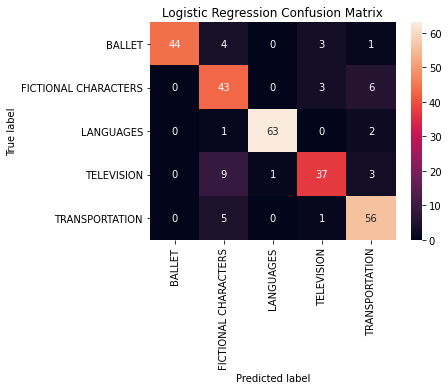

In [36]:
# Confusion matrix for the logistic regression model
confusion_mc = confusion_matrix(y_test, LR_y_pred)
df_cm = pd.DataFrame(confusion_mc, 
                     index = ['BALLET','FICTIONAL CHARACTERS','LANGUAGES','TELEVISION','TRANSPORTATION'], 
                     columns = ['BALLET','FICTIONAL CHARACTERS','LANGUAGES','TELEVISION','TRANSPORTATION'])

plt.figure(figsize=(5.5,4))
sns.heatmap(df_cm, annot=True)
plt.title('Logistic Regression Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label');

The most frequent misclassification is classifying Television clues as Fictional Characters clues, with 9 occurences, followed by classifying Fictional Characters clues as Transportation clues, with 6 occurrences. Overall, though, there is not a great deal of misclassification.

## Word Cloud of Transportation Clues

A neat way to see the most frequent words is a word cloud. Here I will build a word cloud for clues in the Transportation category.

In [37]:
# Combine all the words from the cleaned Transportation clues into a string
transportation_words = ' '.join([word for word in df_WC_Transportation['Clue']])

# Since stop word removal was done as part of the vectorization above, I still need to remove
# the stop words from the clues here

# Function to omit stop words
def omit_stopwords(text):
    # Create empty list for words that will be kept
    list_words = []
    # Split the text into individual words
    for word in text.split():
        # Append words that are not stop words to the list of words
        if word not in total_stop_words:
            list_words.append(word)
    # Combine all the words which are kept into a string        
    return ' '.join(word for word in list_words)

text_for_transportation_cloud = omit_stopwords(transportation_words)

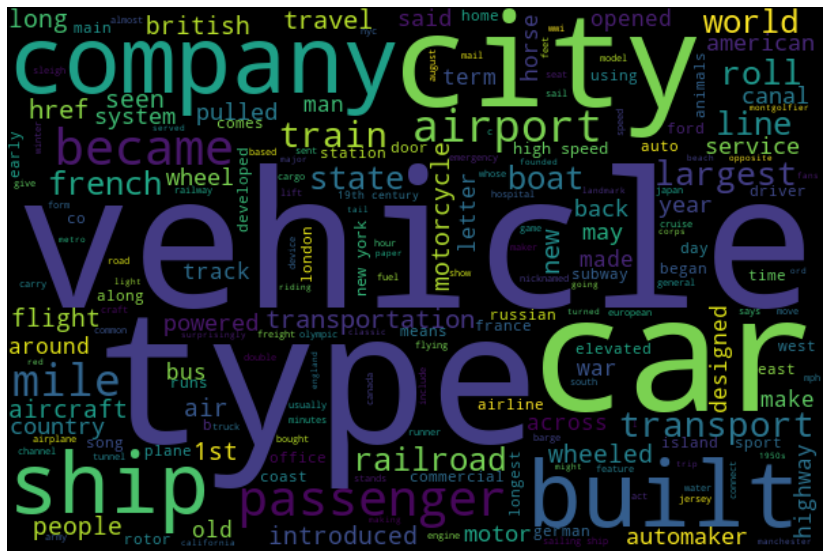

In [38]:
# Plot the Transportation word cloud
wordcloud = WordCloud(width=600, height=400).generate(text_for_transportation_cloud)
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off');